<a href="https://colab.research.google.com/github/pvpogorelova/metrics_24_25/blob/main/sem_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Генерация отрицательного биномиального распределения (как смесь Пуассона и Гамма)**

In [25]:
import numpy as np
from scipy.stats import gamma, poisson

* $n$ — число наблюдений

* $mu$ — вектор средних значений, вычисленных как экспонента от случайной нормальной величины (логарифмическая связь, как в регрессии).

* $1 + 0.5 * np.random.normal(size=n)$ — линейный предиктор (1 — intercept, 0.5 — коэффициент, умноженный на нормальный шум).

* $alpha = 0.5$ — параметр, отвечающий за перерассеяние (чем больше, тем сильнее дисперсия превышает среднее).

In [26]:
# Задаём параметры
np.random.seed(777)  # для воспроизводимости

n = 1000
mu = np.exp(1 + 0.5 * np.random.normal(size=n))  # систематическая часть
alpha = 0.5  # параметр перерассеяния

In [27]:
# 2. Генерируем lambda_i из гамма-распределения
# В scipy.stats.gamma используются параметры shape (k) и scale (theta)
# где shape = 1/alpha, scale = alpha * mu
lambda_ = gamma.rvs(a=1/alpha, scale=alpha * mu, size=n)

In [28]:
# 3. Генерируем Y_i из Пуассона с lambda_i
y = poisson.rvs(mu = lambda_)

# Проверяем перерассеяние: дисперсия >> среднего
print(f"Среднее: {np.mean(y):.2f}")  # ~ E(Y)
print(f"Дисперсия: {np.var(y):.2f}")  # ~ Var(Y) = E(Y) + alpha * E(Y)^2
print(f"Отношение дисперсии к среднему: {np.var(y)/np.mean(y):.2f}")

Среднее: 3.15
Дисперсия: 12.76
Отношение дисперсии к среднему: 4.05


Так как отношение дисперсии к среднему больше 1, то данные действительно получены из отрицательного биномиального распределения.

## **Модели счётных данных.**

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Загрузка данных
crime = pd.read_stata("crime.dta")

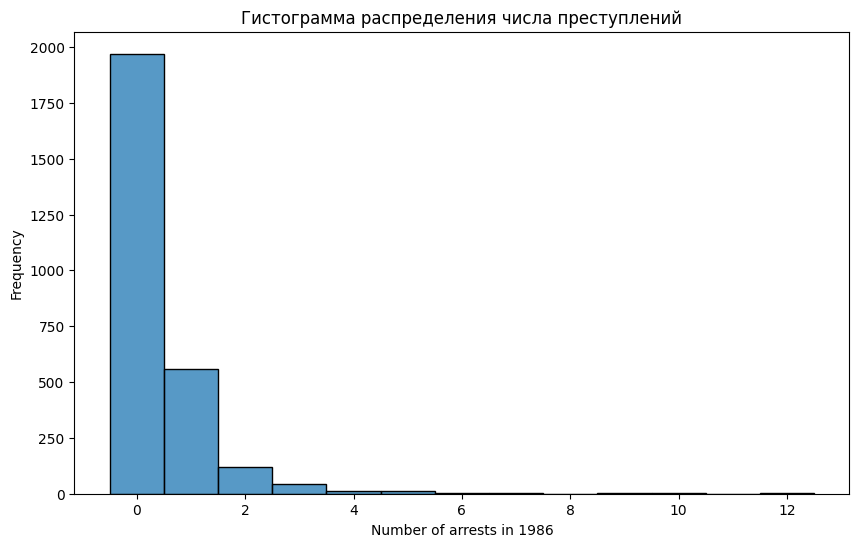

In [ ]:
# Гистограмма распределения числа преступлений
plt.figure(figsize=(10, 6))
sns.histplot(data=crime, x="narr86", discrete=True)
plt.title("Гистограмма распределения числа преступлений")
plt.xlabel("Number of arrests in 1986")
plt.ylabel("Frequency")
plt.show()

In [5]:
# Линейная регрессия (МНК) - без учёта специфики зависимой переменной
ols_formula = "narr86 ~ pcnv + avgsen + tottime + ptime86 + qemp86 + inc86 + durat + black + hispan + born60"
ols_model = smf.ols(ols_formula, data=crime).fit(cov_type='HC1')
print(ols_model.summary())

crime['narr86_f_ols'] = ols_model.predict()

                            OLS Regression Results                            
Dep. Variable:                 narr86   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     24.22
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           2.78e-44
Time:                        09:03:39   Log-Likelihood:                -3349.2
No. Observations:                2725   AIC:                             6720.
Df Residuals:                    2714   BIC:                             6785.
Df Model:                          10                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6001      0.053     11.243      0.0

In [6]:
# Пуассоновская регрессия
poisson_formula = "narr86 ~ pcnv + avgsen + tottime + ptime86 + qemp86 + inc86 + durat + black + hispan + born60"
poisson_model = smf.poisson(poisson_formula, data=crime).fit(cov_type='HC1')
print(poisson_model.summary())

Optimization terminated successfully.
         Current function value: 0.824960
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:                 narr86   No. Observations:                 2725
Model:                        Poisson   Df Residuals:                     2714
Method:                           MLE   Df Model:                           10
Date:                Fri, 25 Apr 2025   Pseudo R-squ.:                 0.07941
Time:                        09:03:42   Log-Likelihood:                -2248.0
converged:                       True   LL-Null:                       -2441.9
Covariance Type:                  HC1   LLR p-value:                 3.694e-77
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5513      0.105     -5.246      0.000      -0.757      -0.345
pcnv          -0.4031      0.

Incident Rate Ratio (IRR) показывает, во сколько раз изменится ожидаемое количество событий (преступлений) при увеличении фактора $x_j$ на 1 единицу (при фиксированных значений остальных переменных).
$$IRR_j = exp(\beta_j)$$.
Интерпретация:
* если $IRR = 1$, то $x_j$ не влияет на частоту событий;
* если $IRR > 1$, то увеличение $x_j$ на 1 единицу **увеличивает** частоту событий в $exp(\beta_j)$ раз;
* если $IRR < 1$, то увеличение $x_j$ на 1 единицу **уменьшает** частоту событий в $exp(\beta_j)$ раз.

In [7]:
# Incident Rate Ratios
irr = np.exp(poisson_model.params)
print("Incident Rate Ratios:")
print(irr)

Incident Rate Ratios:
Intercept    0.576201
pcnv         0.668235
avgsen       0.976727
tottime      1.024681
ptime86      0.903526
qemp86       0.950312
inc86        0.991975
durat        0.991944
black        1.940420
hispan       1.647129
born60       0.948620
dtype: float64


In [8]:
# доверительные интервалы для IRR
irr_ci = np.exp(poisson_model.conf_int())
irr_ci.columns = ["IRR Lower", "IRR Upper"]
print(pd.concat([irr, irr_ci], axis=1))

                  0  IRR Lower  IRR Upper
Intercept  0.576201   0.468943   0.707991
pcnv       0.668235   0.548465   0.814160
avgsen     0.976727   0.932744   1.022784
tottime    1.024681   0.984555   1.066442
ptime86    0.903526   0.863796   0.945083
qemp86     0.950312   0.882607   1.023210
inc86      0.991975   0.989593   0.994364
durat      0.991944   0.975828   1.008327
black      1.940420   1.595909   2.359300
hispan     1.647129   1.374697   1.973551
born60     0.948620   0.809255   1.111986


In [9]:
# Прогноз числа преступлений
crime['narr86_f_p'] = poisson_model.predict()

In [10]:
# Goodness-of-fit тест
residuals = crime['narr86'] - crime['narr86_f_p']
chi2_stat = (residuals**2).sum()
print(f"Goodness-of-fit chi2 statistic: {chi2_stat}")


Goodness-of-fit chi2 statistic: 1853.680094369524


In [11]:
# Пуассоновская регрессия с факторной переменной black
poisson_formula_factor = "narr86 ~ pcnv + avgsen + tottime + ptime86 + qemp86 + inc86 + durat + C(black) + hispan + born60"
poisson_model_factor = smf.poisson(poisson_formula_factor, data=crime).fit(cov_type='HC1')


Optimization terminated successfully.
         Current function value: 0.824960
         Iterations 6


In [12]:
# Прогнозируемое количество преступлений для разных значений black при средних значениях других переменных
atmeans = crime.mean().to_frame().T
atmeans = atmeans.drop(columns=['narr86', 'narr86_f_ols', 'narr86_f_p'], errors='ignore')

predictions = []
for black_val in [0, 1]:
    temp = atmeans.copy()
    temp['black'] = black_val
    pred = poisson_model_factor.predict(temp)
    predictions.append(pred.iloc[0])

print(f"Predicted crimes for black=0: {predictions[0]:.2f}")
print(f"Predicted crimes for black=1: {predictions[1]:.2f}")

Predicted crimes for black=0: 0.30
Predicted crimes for black=1: 0.57


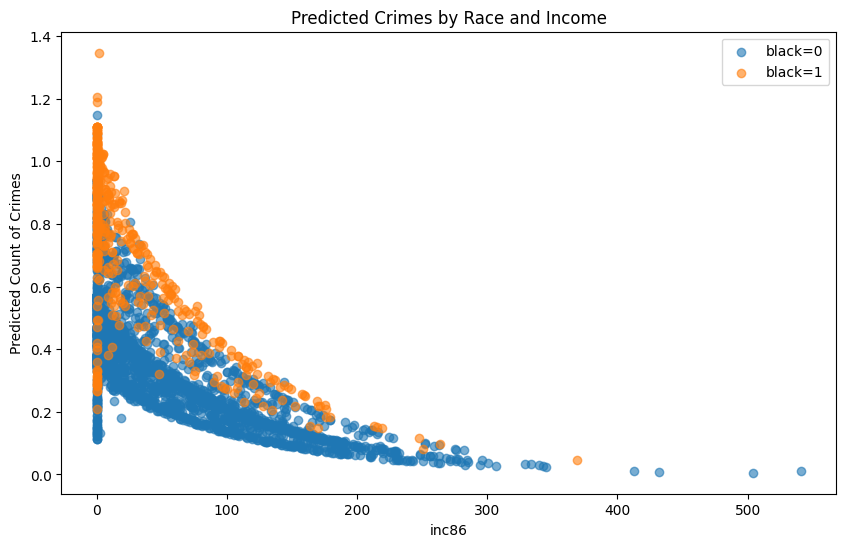

In [13]:
# График прогнозируемого числа преступлений
plt.figure(figsize=(10, 6))
for black_val in [0, 1]:
    subset = crime[crime['black'] == black_val]
    plt.scatter(subset['inc86'], poisson_model_factor.predict(subset),
                label=f'black={black_val}', alpha=0.6)

plt.xlabel('inc86')
plt.ylabel('Predicted Count of Crimes')
plt.title('Predicted Crimes by Race and Income')
plt.legend()
plt.show()

In [14]:
# Отрицательная биномиальная регрессия (NB-I)
nb1_formula = "narr86 ~ pcnv + avgsen + tottime + ptime86 + qemp86 + inc86 + durat + black + hispan + born60"
nb1_model = smf.negativebinomial(nb1_formula, data=crime, loglike_method='nb1').fit()
print(nb1_model.summary())

         Current function value: 0.793994
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42
                     NegativeBinomial Regression Results                      
Dep. Variable:                 narr86   No. Observations:                 2725
Model:               NegativeBinomial   Df Residuals:                     2714
Method:                           MLE   Df Model:                           10
Date:                Fri, 25 Apr 2025   Pseudo R-squ.:                 0.05547
Time:                        09:04:18   Log-Likelihood:                -2163.6
converged:                      False   LL-Null:                       -2290.7
Covariance Type:            nonrobust   LLR p-value:                 7.410e-49
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6368      0.091     -7.001      0.000      -0.815      -0.4

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
# Incident Rate Ratios для NB-I
irr_nb1 = np.exp(nb1_model.params)
print("NB1 Incident Rate Ratios:")
print(irr_nb1)

NB1 Incident Rate Ratios:
Intercept    0.528964
pcnv         0.572239
avgsen       0.986665
tottime      1.017423
ptime86      0.902736
qemp86       1.001641
inc86        0.992456
durat        1.002792
black        1.863573
hispan       1.567036
born60       0.985032
alpha        1.584487
dtype: float64


In [20]:
# доверительные интервалы для IRR
irr_ci_nb1 = np.exp(nb1_model.conf_int())
irr_ci_nb1.columns = ["IRR Lower", "IRR Upper"]
print(pd.concat([irr_nb1, irr_ci], axis=1))

                  0  IRR Lower  IRR Upper
Intercept  0.528964   0.442580   0.632207
pcnv       0.572239   0.470876   0.695423
avgsen     0.986665   0.940530   1.035064
tottime    1.017423   0.979304   1.057026
ptime86    0.902736   0.858341   0.949427
qemp86     1.001641   0.935394   1.072580
inc86      0.992456   0.990307   0.994609
durat      1.002792   0.988234   1.017565
black      1.863573   1.574280   2.206028
hispan     1.567036   1.325194   1.853013
born60     0.985032   0.852934   1.137590
alpha      1.584487   1.416961   1.771819


In [22]:
crime['narr86_f_nb1'] = nb1_model.predict()

In [21]:
# Отрицательная биномиальная регрессия (NB-II)
nb2_formula = "narr86 ~ pcnv + avgsen + tottime + ptime86 + qemp86 + inc86 + durat + C(black) + C(hispan) + C(born60)"
nb2_model = smf.negativebinomial(nb2_formula, data=crime, loglike_method='nb2').fit()
print(nb2_model.summary())

crime['narr86_f_nb2'] = nb2_model.predict()

Optimization terminated successfully.
         Current function value: 0.791672
         Iterations: 34
         Function evaluations: 40
         Gradient evaluations: 40
                     NegativeBinomial Regression Results                      
Dep. Variable:                 narr86   No. Observations:                 2725
Model:               NegativeBinomial   Df Residuals:                     2714
Method:                           MLE   Df Model:                           10
Date:                Fri, 25 Apr 2025   Pseudo R-squ.:                 0.05823
Time:                        09:06:41   Log-Likelihood:                -2157.3
converged:                       True   LL-Null:                       -2290.7
Covariance Type:            nonrobust   LLR p-value:                 1.606e-51
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5243     

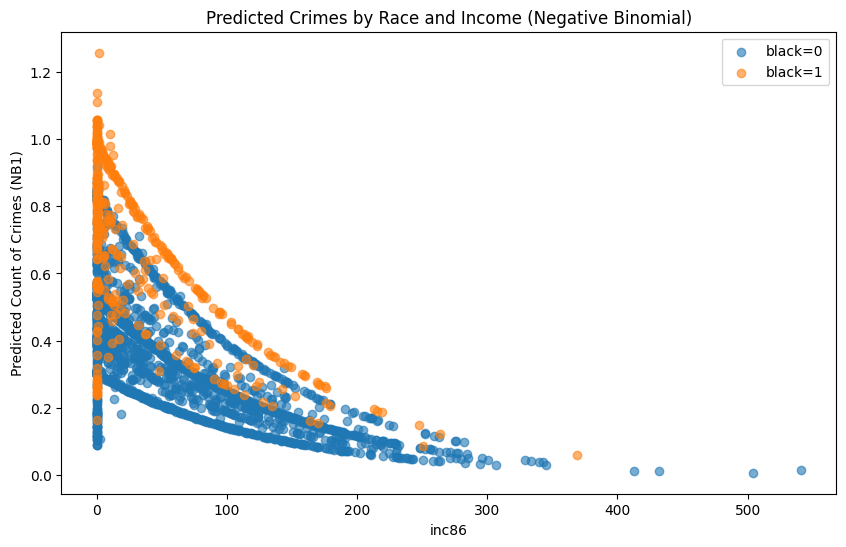

In [24]:
# График прогнозов числа преступлений для отрицательной биномиальной регрессии
plt.figure(figsize=(10, 6))
for black_val in [0, 1]:
    subset = crime[crime['black'] == black_val]
    plt.scatter(subset['inc86'], nb1_model.predict(subset),
                label=f'black={black_val}', alpha=0.6)

plt.xlabel('inc86')
plt.ylabel('Predicted Count of Crimes (NB1)')
plt.title('Predicted Crimes by Race and Income (Negative Binomial)')
plt.legend()
plt.show()